# What Twitter Users Think About...

### Author: Kobi Zohar

## Importing the relevant libreries

In [768]:
import pandas as pd
import numpy as np
import csv
import twitter
import json
import translate
from translate import Translator
import translate
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from wordcloud import WordCloud, STOPWORDS
from urllib.parse import unquote
from collections import Counter
from prettytable import PrettyTable

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

from datetime import datetime


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\zoharko\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Twitter API Credentials

In [769]:
CONSUMER_KEY = 'iPFmqWGXynF8JMwCV5SwExNMV'
CONSUMER_SECRET = 'dRdVoJ8V8nGiCWAt41Vfgz92kvIJhJTpNd2uY6j4D9hQtcd9x9'
OAUTH_TOKEN = '1105395440894296064-xVKPRob8k7a1l1W58Xgy7AiArx3z4f'
OAUTH_TOKEN_SECRET = 'jZsR0Vf61QpwRvP36yFrorgpjtduYxgaCXik4b40wrHwu'

auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                           CONSUMER_KEY, CONSUMER_SECRET)

twitter_api = twitter.Twitter(auth=auth)
print(twitter_api)


## Dictionaray for Twitter Optional Langas

In [770]:
lang_csv_path='C:/Users/zoharko/Documents/Python Scripts/twitter lang codes2.csv'
lang_dict=pd.read_csv(lang_csv_path, header=None, index_col=0, squeeze=True).to_dict()
lang_dict.keys()

dict_keys(['am', 'ar', 'bg', 'bn', 'bo', 'bs', 'ca', 'ckb', 'cs', 'cy', 'da', 'de', 'dv', 'el', 'en', 'es', 'et', 'eu', 'fa', 'fi', 'fr', 'gu', 'he', 'hi', 'hi-Latn', 'hr', 'ht', 'hu', 'hy', 'id', 'is', 'it', 'ja', 'ka', 'km', 'kn', 'ko', 'lo', 'lt', 'lv', 'ml', 'mr', 'ms', 'my', 'ne', 'nl', 'no', 'pa', 'pl', 'ps', 'pt', 'ro', 'ru', 'sd', 'si', 'sk', 'sl', 'sr', 'sv', 'ta', 'te', 'th', 'tl', 'tr', 'ug', 'uk', 'ur', 'vi', 'zh-CN', 'zh-TW', 'und', 'in', 'iw'])

## Getting User Inputs

In [771]:
search = input("Enter Your Tpoic: ")

Enter Your Tpoic: #Israel


## API Query

In [772]:
q = search
count = 100
search_results = twitter_api.search.tweets(q=q, count=count)
statuses=search_results['statuses']

for _ in range(10):
    print('Length of statuses', len(statuses))
    try:
        next_results = search_results['search_metadata']['next_results']
    except KeyError as e: 
        break
        
    kwargs = dict([ kv.split('=') for kv in unquote(next_results[1:]).split("&") ])
    
    search_results = twitter_api.search.tweets(**kwargs)
    statuses += search_results['statuses']



Length of statuses 58
Length of statuses 123
Length of statuses 191
Length of statuses 265
Length of statuses 334
Length of statuses 401
Length of statuses 456
Length of statuses 515
Length of statuses 585
Length of statuses 653


In [776]:
len(statuses)

707

## Extracting & Manipulating the Data

In [785]:
tweet_data=[]
for status in statuses:
    if 'retweeted_status' in status.keys():
        if status['lang']=='en':
            tweet_data.append([status['text'],status['retweet_count'],status['retweeted_status']['favorite_count'],status['retweeted_status']['user']['location']])
        else:
            tweet_data.append([(Translator(from_lang=lang_dict[status['lang']],to_lang="english").translate(status['text'])),status['retweet_count'],status['retweeted_status']['favorite_count'],status['retweeted_status']['user']['location']])
    else:
        pass
            

In [795]:
tweet_data_df=pd.DataFrame(tweet_data)
tweet_data_df.rename(columns={0:'Text', 1:'Retweet_Count',2:'Favorite_Count',3:'Location'}, inplace=True)
tweet_data_df=tweet_data_df[~tweet_data_df['Text'].str.contains("MYMEMORY WARNING")]
print(len(tweet_data_df))
tweet_data_df.head()

434


,Text,Retweet_Count,Favorite_Count,Location
0,RT @ MIsBack8: #christians you can vote tomorr...,1,0,
1,RT @JewsVsIsrael: #Israel is not a #Jewish Sta...,64,80,"Brooklyn, NY"
2,RT @HeroNapit: #Palestine: Gaza investigators ...,18,9,
3,"RT @ tdenooijer: Yesterday, @keesvdstaaij spok...",33,83,"Oldebroek, Nederland"
4,RT @evacool_: #BREAKING #NOW\nFour large explo...,37,31,Greece


In [798]:
status_texts=[text for text in tweet_data_df['Text']]


"RT @JewsVsIsrael: #Israel is not a #Jewish State, it's a #Zionist State!\nhttps://t.co/u3qNZumMxN"

In [1057]:
words = [ w 
          for t in status_texts 
              for w in t.split() ]

#removing https from words
for el in words:
    if el.find('https://')==0:
        words.remove(el)
    else:
        pass

In [801]:
tweet_data_df['Text_Sentiment']=[analyzer.polarity_scores(text)['compound'] for text in tweet_data_df['Text']]

In [802]:
tweet_data_df.head()

,Text,Retweet_Count,Favorite_Count,Location,Text_Sentiment
0,RT @ MIsBack8: #christians you can vote tomorr...,1,0,,0.4404
1,RT @JewsVsIsrael: #Israel is not a #Jewish Sta...,64,80,"Brooklyn, NY",0.0000
2,RT @HeroNapit: #Palestine: Gaza investigators ...,18,9,,-0.3818
3,"RT @ tdenooijer: Yesterday, @keesvdstaaij spok...",33,83,"Oldebroek, Nederland",0.8172
4,RT @evacool_: #BREAKING #NOW\nFour large explo...,37,31,Greece,0.0000


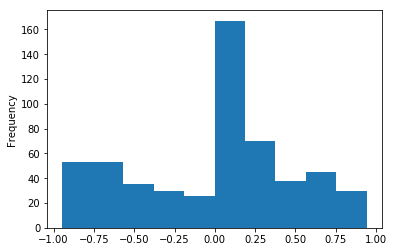

In [803]:
df['Text_Sentiment'].plot(kind='hist')

## Words Frq. Analysis

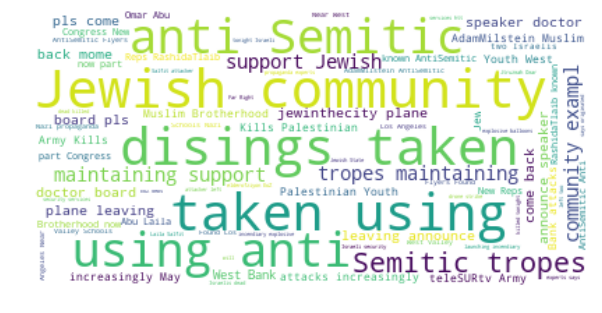

In [1059]:
stopwords = set(STOPWORDS)

# add list of words to stopwords
add_words=[search.replace('#',''),'RT','https co','yalvareztv quot','mojos55','de','IlhanMN','Partisangirl','5G','6G','Ea4Fx1ylJS','eSPAINews','DBenzheimer']
[stopwords.add(stwo) for stwo in add_words]

words_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
words_wc.generate(" ".join(words))
words_wc.words_
fig = plt.figure()
fig.set_figwidth(10) # set width
fig.set_figheight(10) # set height

plt.imshow(words_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Calculating the Lexical Diversity for Tweets

In [1060]:
def lexical_diversity(tokens):
    return len(set(tokens))/len(tokens) 

# A function for computing the average number of words per tweet
def average_words(statuses):
    total_words = sum([ len(s.split()) for s in statuses ]) 
    return total_words/len(statuses)

print(lexical_diversity(words))
print(average_words(status_texts))

0.2547137073452863
20.14516129032258


## Preparing the Data Toward Users Ditribution Ploted on World Map

In [764]:
table=[]
for i in range(len(statuses)):
    try: table.append([tweet_data[i][0],analyzer.polarity_scores(tweet_data[i][0])['compound'],statuses[i]['retweeted_status']['user']['location']])
    except: KeyError: 'retweeted_status'


In [860]:
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
geolocator = Nominatim(user_agent="foursquare_agent")


,Text,Retweet_Count,Favorite_Count,Location,Text_Sentiment,Latitude
491,RT @PrivateFuel: https://t.co/FNEosAbnQt #Exxo...,9,4,Domain name for Sale,0.0,24.3
492,RT @PrivateFuel: https://t.co/FNEosAbnQt #Exxo...,9,4,Domain name for Sale,0.0,24.3
493,RT @PrivateFuel: https://t.co/FNEosAbnQt #Exxo...,9,4,Domain name for Sale,0.0,24.3
494,RT @PrivateFuel: https://t.co/FNEosAbnQt #Exxo...,9,4,Domain name for Sale,0.0,24.3
495,RT @GazaAI1: The Year of the People: The Untol...,7,4,Ireland,0.0,24.3


In [883]:
tweet_data_df['Latitude']=['None' for i in tweet_data_df['Text']]
tweet_data_df['Longtitude']=['None' for i in tweet_data_df['Text']]
for i,address in enumerate(tweet_data_df['Location']):
    if address=='':
        tweet_data_df['Latitude'][i]='None'
        tweet_data_df['Longtitude'][i]='None'

    else:
        try:
            a=geolocator.geocode(address)
            tweet_data_df['Latitude'][i]=a.latitude
            tweet_data_df['Longtitude'][i]=a.longitude
        except:
            AttributeError
            

C:\Users\zoharko\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\zoharko\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\zoharko\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by Interactiv

In [963]:
tweet_data_df1=tweet_data_df
len(tweet_data_df)

434

In [971]:
df_loc=tweet_data_df[(tweet_data_df['Latitude']!='None')]
df_loc=df_loc[(df_loc['Latitude']!='None')]
df_loc.reset_index(drop=True, inplace=True)
df_loc.drop_duplicates(subset=['Text_Sentiment','Location'],keep='first')
len(df_loc)

C:\Users\zoharko\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


168

In [973]:
world_map = folium.Map(prefer_canvas=True)

def plotDot(point):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    if point['Text_Sentiment']>0:  # positive sentiment
        folium.Marker(location=[point['Latitude'], point['Longtitude']],icon = folium.Icon(color='green')).add_to(world_map)
    else:
        if point['Text_Sentiment']<0:
            folium.Marker(location=[point['Latitude'], point['Longtitude']],icon = folium.Icon(color='red')).add_to(world_map)
        else:
            folium.Marker(location=[point['Latitude'], point['Longtitude']],icon = folium.Icon(color='gray')).add_to(world_map)
 


 #use df.apply(,axis=1) to "iterate" through every row in your dataframe
df_loc.apply(plotDot, axis = 1)


#Set the zoom to the maximum possible
world_map.fit_bounds(this_map.get_bounds())

#Save the map to an HTML file
world_map.save('C:/Users/zoharko/Documents/Python Scripts/simple_dot_plot.html')

world_map

## Results Sammry

In [983]:
record_list=[[str(datetime.today()),int(tweet_data_df['Retweet_Count'].mean()),int(tweet_data_df['Favorite_Count'].mean()),round(tweet_data_df['Text_Sentiment'].mean(),3),lexical_diversity(words),average_words(status_texts)]]
record_df=pd.DataFrame(record_list)
record_df.rename(columns={0:'Time Stamp', 1:'Average Retweet',2:'Average Favorite',3:'Average Sentiment',4:'Lexical Diversity',5:'Avg Words per Tweet'}, inplace=True)
record_df

,Time Stamp,Average Retweet,Average Favorite,Average Sentiment,Lexical Diversity,Avg Words per Tweet
0,2019-03-20 18:06:32.693279,88,241,-0.034,0.257577,20.145161


## Saving to CSV File

In [984]:
save_path='C:/Users/zoharko/Documents/Python Scripts/Israel results1.csv'
row = [record_df['Time Stamp'][0],record_df['Average Retweet'][0], record_df['Average Favorite'][0],record_df['Average Sentiment'][0],record_df['Lexical Diversity'][0],record_df['Avg Words per Tweet'][0]]
with open(save_path, 'a') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerow(row)
csvFile.close()